## Sequence Prediction using RNN

The task of this quiz is to create an RNN model for Sequence Prediction.
In this case we are predicting the next value based on the previously observed sequence.

Hint: We can think of this as a regression problem and select the loss function accordingly.



In [1]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Given data.

In [2]:
def create_data():
    sin_wave = np.array([math.sin(x) for x in np.arange(200)])
    X = []
    Y = []
    seq_len = 50
    num_records = len(sin_wave) - seq_len
    for i in range(num_records - 50):
        X.append(sin_wave[i:i+seq_len])
        Y.append(sin_wave[i+seq_len]) # Each sample of y_train is the value at timestep of X_train + 50ใ
    X = np.array(X)
    X = np.expand_dims(X, axis=2)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=1)
    return torch.from_numpy(X), torch.from_numpy(Y)

There are 100 samples of X_train data and 100 corresponding y_train data.

In [3]:
X_train, y_train = create_data()
print(X_train.shape)
print(y_train.shape)

torch.Size([100, 50, 1])
torch.Size([100, 1])


## Understanding the data.

Each sample of X_train is a sequence that includes 50 timesteps.

1. Plot a 2D line plot of the first sample of X_train. ( 1 point )

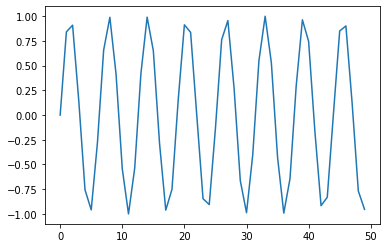

In [4]:
# < your code here >
plt.plot(X_train[0])
plt.show()

Each sample of y_train is the value at time step 51 after X_train.

2. Plot the same plot from the previous question. Then, add a scatter plot for the corresponding y_train. ( 1 point )

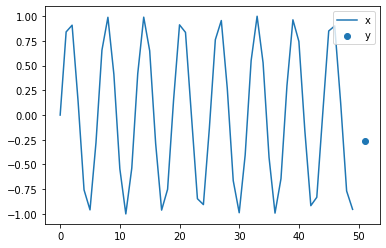

In [5]:
# < your code here >
plt.plot(X_train[0], label='x')
plt.scatter(51, y_train[0], label='y')
plt.legend()
plt.show()

3. Define an RNN model class with one RNN layer (num_layers = 1) followed by one Fully Connected layer. ( 3 points )

**The class should take input_dim, hidden_dim and output_dim as inputs.


In [6]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1): # < your code here >
        super().__init__()
        
        # < your code here >
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        output, hn = self.rnn(x)
        assert torch.equal(output[:,-1,:], hn.squeeze(0))
        return self.fc(hn.squeeze(0))

4. Create a model object with the following hyperparameters ( 1 point )

    hidden_dim = 50, 
    output_dim = 1

In [7]:
# < your code here >
input_dim = 1
hidden_dim = 50
output_dim = 1
num_layers = 1
model = RNN(input_dim, hidden_dim, output_dim, num_layers)

# Then do 
model.double()

RNN(
  (rnn): RNN(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

5. Initialize the weights of the model with the given function. ( 1 point )

In [8]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)

In [9]:
# < your code here >
model.apply(initialize_weights)

RNN(
  (rnn): RNN(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

# Training hyperparameters
    batch_size = 16
    num_epochs = 10
    lr         = 1e-3

In [10]:
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset( X_train, y_train )

6. Create a dataloader from the given dataset using batch_size given above. ( 1 points )

In [11]:
# < your code here >
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

batch_size = 16
# train_dataset = to_map_style_dataset(X_train)
num_train = int(len(X_train) * 0.95)
split_train_, split_valid_ = \
    random_split(X_train, [num_train, len(X_train) - num_train])
train_loader = DataLoader(split_train_, batch_size=batch_size,
                              shuffle=True)

7. Define an optimizer for training the model using lr given above. ( 1 point )

In [12]:
# < your code here >
import torch.optim as optim

num_epochs = 10
lr = 1e-3
optimizer = optim.SGD(model.parameters(), lr=lr)

8. Define a loss funcriterion for training a regression model. ( 1 point )



In [13]:
# < your code here >
criterion = nn.CrossEntropyLoss()

9. Define a training loop or function that can train the model for 10 epochs and also print out the training loss of each epoch ( 2 points )

In [14]:
# < your code here >
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (label, text) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        # acc = binary_accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        # epoch_acc += acc.item()
                
    return epoch_loss / len(loader)

10. Excecute the code for training the model for 10 epochs and print out the training loss of each epochs. ( 3 points )

In [15]:
# < your code here >